In [1]:
!curl -L https://www.dropbox.com/s/rndzndlgpw3coiq/kaggle-download.zip -o kaggle-download.zip
!unzip kaggle-download.zip -d kaggle_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     57      0 --:--:-- --:--:-- --:--:--    57
100   340  100   340    0     0    478      0 --:--:-- --:--:-- --:--:--     0
100   534    0   534    0     0    425      0 --:--:--  0:00:01 --:--:--   425
 41  515M   41  212M    0     0  46.1M      0  0:00:11  0:00:04  0:00:07 70.7M^C
Archive:  kaggle-download.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of kaggle-download.zip or
        kaggle-download.zip.zip, and cannot find kaggle-download.zip.ZIP, period.


In [108]:
pip install xgboost

SyntaxError: invalid syntax (4035839222.py, line 1)

In [109]:
pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.6 MB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 840 kB 57.8 MB/s eta 0:00:01
     |████████████████████████████████| 200 kB 53.3 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492026 sha256=ec372d44630e94bb8052c2a3a28630c7890d98d786025dd7107cdf093e6684fb
  Stored in directory: /home/acz001/.cache/pip/wheels/bf/5d/6a/2e53874f7ec4e2bede522385439531fafec8fafe005b5c3d1b
Successfully built future
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import xgboost
import sklearn

# Processing data

In [3]:
# These are all of the files you are given
df_tr = pd.read_csv("kaggle_data/train.csv")

# getting rid of incomplete rows
original_rows = df_tr.shape[0]

df_tr = df_tr.loc[df_tr['MISSING_DATA'] == False]

rows_removed = original_rows - df_tr.shape[0]
print(f"{rows_removed=}")
    
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

rows_removed=10


In [4]:
df_taxi_data = pd.read_csv("kaggle_data/metaData_taxistandsID_name_GPSlocation.csv")
# The following code normalizes longitudes and latitudes.
# df_taxi_data["Longitude"] = (df_taxi_data["Longitude"] - df_taxi_data["Longitude"].mean()) / df_taxi_data["Longitude"].std()
# df_taxi_data["Latitude"] = (df_taxi_data["Latitude"] - df_taxi_data["Latitude"].mean()) / df_taxi_data["Latitude"].std()

In [5]:
from datetime import datetime
import math

def process_df(df):
    def parse_time(x):
        # We are using python's builtin datetime library
        # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

        # Each x is essentially a 1 row, 1 column pandas Series
        dt = datetime.fromtimestamp(x["TIMESTAMP"])
        return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

    def get_lat_long(x):
        if math.isnan(x["ORIGIN_STAND"]):
            return 0, 0
        taxi_row = df_taxi_data.iloc[int(x["ORIGIN_STAND"]) - 1]
        return float(taxi_row["Latitude"]), float(taxi_row["Longitude"])
    
    df[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
    df[["LATITUDE", "LONGITUDE"]] = df_tr[["ORIGIN_STAND"]].apply(get_lat_long, axis=1, result_type="expand")
    df.drop(['TRIP_ID', "POLYLINE", 'MISSING_DATA'], axis=1, inplace=True, errors="ignore")
    
    categorical_cols = ['CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'DAY_TYPE', 'YR', 'MON', 'DAY', 'HR', 'WK']
    for col in categorical_cols:
        df[col] = df[col].astype('category')
    if 'LEN' in df.columns:
        df['LEN'] = df['LEN'].astype('float64')
    
    return df
    
df_tr = process_df(df_tr)

In [28]:
df_tr.head(10)

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,LEN,YR,MON,DAY,HR,WK,LATITUDE,LONGITUDE
0,C,NaN,NaN,20000589,1372636858,A,330.0,2013,7,1,0,0,0.00000,0.000000
1,B,NaN,7.0,20000596,1372637303,A,270.0,2013,7,1,0,0,41.15998,-8.641984
2,C,NaN,NaN,20000320,1372636951,A,960.0,2013,7,1,0,0,0.00000,0.000000
3,C,NaN,NaN,20000520,1372636854,A,630.0,2013,7,1,0,0,0.00000,0.000000
4,C,NaN,NaN,20000337,1372637091,A,420.0,2013,7,1,0,0,0.00000,0.000000
5,C,NaN,NaN,20000231,1372636965,A,375.0,2013,7,1,0,0,0.00000,0.000000
6,C,NaN,NaN,20000456,1372637210,A,525.0,2013,7,1,0,0,0.00000,0.000000
7,C,NaN,NaN,20000011,1372637299,A,495.0,2013,7,1,0,0,0.00000,0.000000
8,C,NaN,NaN,20000403,1372637274,A,555.0,2013,7,1,0,0,0.00000,0.000000
9,C,NaN,NaN,20000320,1372637905,A,270.0,2013,7,1,0,0,0.00000,0.000000


In [ ]:
# Data visualization of all trip times
plt.hist(raw_train[1].tolist(), bins=50, range=(0, 5000), linewidth=1, edgecolor='black')
plt.xlabel('Taxi Trip Time')
plt.ylabel('Frequency')
plt.show()

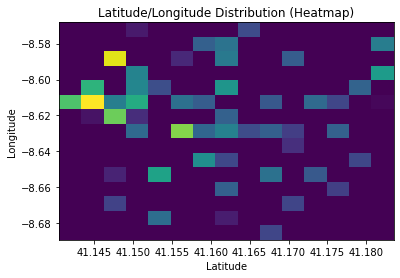

In [30]:
# Heatmap visualization of trip start points
import matplotlib.colors as mcolors
plt.hist2d(latlong[0], latlong[1], bins=15, norm=mcolors.PowerNorm(0.5))
plt.title('Latitude/Longitude Distribution (Heatmap)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X = df_tr.drop('LEN', axis=1)
y = df_tr['LEN']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.1)

# Model training

In [7]:
import xgboost as xgb

dfull_reg = xgb.DMatrix(X, y, enable_categorical=True)
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [12]:
# Hyperparameters

params = { "objective":"reg:squarederror", "tree_method":"gpu_hist", "seed": 0, 'colsample_bytree': 0.55,
 'eta': 0.1,
 'gamma': 0.65,
 'max_depth': 7,
 'min_child_weight': 5.0,
 'reg_alpha': 45.0,
 'reg_lambda': 0.8,
 'subsample': 0.8}
{'colsample_bytree': 0.7000000000000001,
 'eta': 0.025,
 'gamma': 0.55,
 'max_depth': 9,
 'min_child_weight': 4.0,
 'n_estimators': 806,
 'subsample': 0.9500000000000001}

n = 10000
EARLY_STOP = 50

In [9]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error

xgb.set_config(verbosity=0)

N_HP_DATA = 10000
dtrainHP_reg = xgb.DMatrix(X_train.head(9 * N_HP_DATA), y_train.head(9 * N_HP_DATA), enable_categorical=True)
dtestHP_reg = xgb.DMatrix(X_test.head(N_HP_DATA), y_test.head(N_HP_DATA), enable_categorical=True)

def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    watchlist = [(dtrainHP_reg, 'train'), (dtestHP_reg, 'eval')]
    model = xgb.train(params, dtrainHP_reg, num_boost_round=1000,
                          evals=watchlist, early_stopping_rounds=EARLY_STOP,
                          verbose_eval=100)
    predictions = model.predict(dtestHP_reg, ntree_limit=model.best_iteration + 1)
    rmse = mean_squared_error(y_test.head(N_HP_DATA), predictions, squared=False)
    print("\RMSE {0}\n\n".format(rmse))
    return {'loss': rmse, 'status': STATUS_OK}

def optimize_hyperparams(random_state=314159265):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda': hp.quniform('reg_lambda', 0, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'rmse',
        'objective': "reg:squarederror",
        'tree_method': 'hist',
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                max_evals=100)
    return best

optimize_hyperparams()

Training with params:                                  
{'colsample_bytree': 0.7000000000000001, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 8, 'min_child_weight': 3.0, 'n_estimators': 239.0, 'objective': 'reg:squarederror', 'reg_alpha': 53.0, 'reg_lambda': 0.6000000000000001, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:877.96548	eval-rmse:860.23606           
[69]	train-rmse:439.17872	eval-rmse:604.56581          
\RMSE 591.8708569309655                                


Training with params:                                                           
{'colsample_bytree': 0.65, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 786.0, 'objective': 'reg:squarederror', 'reg_alpha': 173.0, 'reg_lambda': 0.0, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
[0]	train-rmse:878.25060	eval-rmse:860.18378               

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[72]	train-rmse:538.69333	eval-rmse:590.29883                                   
\RMSE 585.9114595455062                                                         


Training with params:                                                           
{'colsample_bytree': 0.9, 'eta': 0.42500000000000004, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 2, 'min_child_weight': 3.0, 'n_estimators': 815.0, 'objective': 'reg:squarederror', 'reg_alpha': 50.0, 'reg_lambda': 0.55, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
[0]	train-rmse:765.35306	eval-rmse:743.69448                                    
  2%|▏         | 2/100 [00:12<09:28,  5.81s/trial, best loss: 585.9114595455062]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[79]	train-rmse:607.59055	eval-rmse:597.46340                                   
\RMSE 589.83508790482                                                           


Training with params:                                                           
{'colsample_bytree': 0.8500000000000001, 'eta': 0.45, 'eval_metric': 'rmse', 'gamma': 0.9500000000000001, 'max_depth': 10, 'min_child_weight': 3.0, 'n_estimators': 172.0, 'objective': 'reg:squarederror', 'reg_alpha': 153.0, 'reg_lambda': 0.8500000000000001, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
  3%|▎         | 3/100 [00:13<06:07,  3.79s/trial, best loss: 585.9114595455062]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:723.69250	eval-rmse:722.86204                                    
[55]	train-rmse:240.98487	eval-rmse:682.31511                                   
\RMSE 617.7874055052455                                                         


Training with params:                                                           
{'colsample_bytree': 0.75, 'eta': 0.42500000000000004, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 9, 'min_child_weight': 4.0, 'n_estimators': 481.0, 'objective': 'reg:squarederror', 'reg_alpha': 153.0, 'reg_lambda': 0.35000000000000003, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
  4%|▍         | 4/100 [00:34<16:55, 10.58s/trial, best loss: 585.9114595455062]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:766.87676	eval-rmse:748.49534                                    
[53]	train-rmse:322.57263	eval-rmse:654.96721                                   
\RMSE 605.3438200837941                                                         


Training with params:                                                           
{'colsample_bytree': 0.65, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 12, 'min_child_weight': 2.0, 'n_estimators': 160.0, 'objective': 'reg:squarederror', 'reg_alpha': 89.0, 'reg_lambda': 0.6000000000000001, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
  5%|▌         | 5/100 [00:46<17:07, 10.81s/trial, best loss: 585.9114595455062]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:914.88301	eval-rmse:898.84652                                    
[78]	train-rmse:333.58947	eval-rmse:603.42020                                   
\RMSE 593.1418264422516                                                         


Training with params:                                                           
{'colsample_bytree': 1.0, 'eta': 0.325, 'eval_metric': 'rmse', 'gamma': 0.55, 'max_depth': 2, 'min_child_weight': 6.0, 'n_estimators': 458.0, 'objective': 'reg:squarederror', 'reg_alpha': 67.0, 'reg_lambda': 0.9500000000000001, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
[0]	train-rmse:807.64238	eval-rmse:784.75986                                    
  6%|▌         | 6/100 [01:31<35:28, 22.65s/trial, best loss: 585.9114595455062]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[99]	train-rmse:615.29167	eval-rmse:593.14693                                   
\RMSE 592.0506985953292                                                         


Training with params:                                                           
{'colsample_bytree': 0.75, 'eta': 0.45, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 3.0, 'n_estimators': 581.0, 'objective': 'reg:squarederror', 'reg_alpha': 77.0, 'reg_lambda': 0.30000000000000004, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
[0]	train-rmse:759.10306	eval-rmse:738.69126                                    
  7%|▋         | 7/100 [01:33<24:34, 15.86s/trial, best loss: 585.9114595455062]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[60]	train-rmse:532.85847	eval-rmse:615.68270                                   
\RMSE 600.9533140325532                                                         


Training with params:                                                           
{'colsample_bytree': 0.8500000000000001, 'eta': 0.275, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 3, 'min_child_weight': 4.0, 'n_estimators': 574.0, 'objective': 'reg:squarederror', 'reg_alpha': 173.0, 'reg_lambda': 0.35000000000000003, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:826.05976	eval-rmse:804.31653                                    
  8%|▊         | 8/100 [01:36<17:46, 11.59s/trial, best loss: 585.9114595455062]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[72]	train-rmse:596.61188	eval-rmse:593.06906                                   
\RMSE 591.8345434890545                                                         


Training with params:                                                           
{'colsample_bytree': 0.75, 'eta': 0.15000000000000002, 'eval_metric': 'rmse', 'gamma': 0.55, 'max_depth': 3, 'min_child_weight': 3.0, 'n_estimators': 941.0, 'objective': 'reg:squarederror', 'reg_alpha': 106.0, 'reg_lambda': 0.9, 'seed': 314159265, 'subsample': 0.65, 'tree_method': 'hist'}
[0]	train-rmse:890.95867	eval-rmse:872.84896                                    
  9%|▉         | 9/100 [01:37<12:53,  8.50s/trial, best loss: 585.9114595455062]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[98]	train-rmse:602.30430	eval-rmse:592.18248                                   
\RMSE 590.8013640235148                                                         


Training with params:                                                            
{'colsample_bytree': 0.8500000000000001, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 11, 'min_child_weight': 5.0, 'n_estimators': 544.0, 'objective': 'reg:squarederror', 'reg_alpha': 90.0, 'reg_lambda': 0.7000000000000001, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
 10%|█         | 10/100 [01:39<09:48,  6.54s/trial, best loss: 585.9114595455062]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:864.23123	eval-rmse:854.07637                                     
[66]	train-rmse:283.53359	eval-rmse:614.72109                                    
\RMSE 600.3139985319517                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.9500000000000001, 'max_depth': 6, 'min_child_weight': 6.0, 'n_estimators': 501.0, 'objective': 'reg:squarederror', 'reg_alpha': 161.0, 'reg_lambda': 0.30000000000000004, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
[0]	train-rmse:928.60953	eval-rmse:911.15659                                     
 11%|█         | 11/100 [02:15<22:40, 15.28s/trial, best loss: 585.9114595455062]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:552.61984	eval-rmse:584.20167                                   
[103]	train-rmse:551.39501	eval-rmse:584.23746                                   
\RMSE 583.1674568160338                                                          


Training with params:                                                            
{'colsample_bytree': 0.75, 'eta': 0.325, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 2.0, 'n_estimators': 596.0, 'objective': 'reg:squarederror', 'reg_alpha': 58.0, 'reg_lambda': 0.05, 'seed': 314159265, 'subsample': 0.6000000000000001, 'tree_method': 'hist'}
[0]	train-rmse:810.52740	eval-rmse:790.77161                                     
 12%|█▏        | 12/100 [02:20<17:49, 12.15s/trial, best loss: 583.1674568160338]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[90]	train-rmse:608.56925	eval-rmse:602.75868                                    
\RMSE 599.2692065680674                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 877.0, 'objective': 'reg:squarederror', 'reg_alpha': 174.0, 'reg_lambda': 0.55, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:879.08077	eval-rmse:860.52012                                     
 13%|█▎        | 13/100 [02:21<12:58,  8.94s/trial, best loss: 583.1674568160338]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:614.37895	eval-rmse:590.96857                                   
[165]	train-rmse:610.59006	eval-rmse:591.50745                                   
\RMSE 590.1251958207757                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.15000000000000002, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 8, 'min_child_weight': 4.0, 'n_estimators': 742.0, 'objective': 'reg:squarederror', 'reg_alpha': 121.0, 'reg_lambda': 0.75, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 14%|█▍        | 14/100 [02:24<10:06,  7.06s/trial, best loss: 583.1674568160338]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:890.44464	eval-rmse:872.87021                                     
[79]	train-rmse:482.81381	eval-rmse:589.19787                                    
\RMSE 583.1523336549595                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.25, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 8, 'min_child_weight': 4.0, 'n_estimators': 788.0, 'objective': 'reg:squarederror', 'reg_alpha': 83.0, 'reg_lambda': 1.0, 'seed': 314159265, 'subsample': 0.65, 'tree_method': 'hist'}
 15%|█▌        | 15/100 [02:31<10:14,  7.23s/trial, best loss: 583.1523336549595]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:842.76628	eval-rmse:824.22355                                     
[61]	train-rmse:429.76223	eval-rmse:619.67888                                    
\RMSE 592.1471975391104                                                          


Training with params:                                                            
{'colsample_bytree': 0.9500000000000001, 'eta': 0.25, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 10, 'min_child_weight': 2.0, 'n_estimators': 560.0, 'objective': 'reg:squarederror', 'reg_alpha': 145.0, 'reg_lambda': 0.55, 'seed': 314159265, 'subsample': 0.55, 'tree_method': 'hist'}
 16%|█▌        | 16/100 [02:39<10:13,  7.31s/trial, best loss: 583.1523336549595]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:820.02818	eval-rmse:816.33406                                     
[57]	train-rmse:297.06518	eval-rmse:660.15753                                    
\RMSE 623.8643043661336                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.35000000000000003, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 6, 'min_child_weight': 5.0, 'n_estimators': 925.0, 'objective': 'reg:squarederror', 'reg_alpha': 59.0, 'reg_lambda': 0.05, 'seed': 314159265, 'subsample': 0.6000000000000001, 'tree_method': 'hist'}
[0]	train-rmse:798.77737	eval-rmse:779.09265                                     
 17%|█▋        | 17/100 [03:00<15:46, 11.40s/trial, best loss: 583.1523336549595]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[60]	train-rmse:507.69740	eval-rmse:615.22786                                    
\RMSE 590.0699243703615                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 6, 'min_child_weight': 6.0, 'n_estimators': 941.0, 'objective': 'reg:squarederror', 'reg_alpha': 87.0, 'reg_lambda': 0.05, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:915.77705	eval-rmse:898.13489                                     
 18%|█▊        | 18/100 [03:03<12:09,  8.90s/trial, best loss: 583.1523336549595]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:541.01449	eval-rmse:588.78785                                   
[127]	train-rmse:528.28098	eval-rmse:590.00931                                   
\RMSE 587.8250160322822                                                          


Training with params:                                                            
{'colsample_bytree': 0.8500000000000001, 'eta': 0.47500000000000003, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 1, 'min_child_weight': 3.0, 'n_estimators': 927.0, 'objective': 'reg:squarederror', 'reg_alpha': 167.0, 'reg_lambda': 0.05, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
[0]	train-rmse:750.77657	eval-rmse:728.87876                                     
 19%|█▉        | 19/100 [03:09<10:49,  8.02s/trial, best loss: 583.1523336549595]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:624.71628	eval-rmse:597.29479                                   
[157]	train-rmse:624.50832	eval-rmse:597.15014                                   
\RMSE 597.1144122398616                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.9500000000000001, 'max_depth': 13, 'min_child_weight': 1.0, 'n_estimators': 336.0, 'objective': 'reg:squarederror', 'reg_alpha': 129.0, 'reg_lambda': 0.2, 'seed': 314159265, 'subsample': 0.5, 'tree_method': 'hist'}
 20%|██        | 20/100 [03:11<08:18,  6.23s/trial, best loss: 583.1523336549595]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:940.95753	eval-rmse:924.80891                                     
[100]	train-rmse:412.50772	eval-rmse:592.55427                                   
[126]	train-rmse:377.57139	eval-rmse:593.24633                                   
\RMSE 591.7572879494012                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.9, 'max_depth': 4, 'min_child_weight': 5.0, 'n_estimators': 672.0, 'objective': 'reg:squarederror', 'reg_alpha': 122.0, 'reg_lambda': 0.75, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
[0]	train-rmse:941.55133	eval-rmse:924.32615                                     
 21%|██        | 21/100 [04:07<27:58, 21.25s/trial, best loss: 583.1523336549595]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:610.40376	eval-rmse:591.54821                                   
[200]	train-rmse:596.67522	eval-rmse:587.50487                                   
[300]	train-rmse:589.97574	eval-rmse:586.83132                                   
[392]	train-rmse:582.97047	eval-rmse:586.87230                                   
\RMSE 586.7501946131032                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 689.0, 'objective': 'reg:squarederror', 'reg_alpha': 109.0, 'reg_lambda': 0.2, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 22%|██▏       | 22/100 [04:16<22:34, 17.37s/trial, best loss: 583.1523336549595]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:915.69701	eval-rmse:898.22629                                     
[94]	train-rmse:538.94474	eval-rmse:582.58114                                    
\RMSE 581.1641261074896                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 7, 'min_child_weight': 5.0, 'n_estimators': 681.0, 'objective': 'reg:squarederror', 'reg_alpha': 106.0, 'reg_lambda': 0.45, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 23%|██▎       | 23/100 [04:21<17:49, 13.89s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:903.03445	eval-rmse:885.39531                                     
[92]	train-rmse:528.62055	eval-rmse:584.66876                                    
\RMSE 583.3753228495011                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 8, 'min_child_weight': 1.0, 'n_estimators': 696.0, 'objective': 'reg:squarederror', 'reg_alpha': 129.0, 'reg_lambda': 0.75, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 24%|██▍       | 24/100 [04:27<14:33, 11.49s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:954.34236	eval-rmse:937.70273                                     
[100]	train-rmse:568.28567	eval-rmse:594.55793                                   
[200]	train-rmse:525.61908	eval-rmse:586.94056                                   
[300]	train-rmse:496.13894	eval-rmse:586.59018                                   
[339]	train-rmse:485.78713	eval-rmse:586.57850                                   
\RMSE 586.2384433583996                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 373.0, 'objective': 'reg:squarederror', 'reg_alpha': 117.0, 'reg_lambda': 0.2, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 25%|██▌       | 25/100 [04:59<21:54, 17.53s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:903.05015	eval-rmse:885.39705                                     
[100]	train-rmse:520.87659	eval-rmse:584.33091                                   
[118]	train-rmse:510.94527	eval-rmse:586.05156                                   
\RMSE 581.449343960037                                                           


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.225, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 405.0, 'objective': 'reg:squarederror', 'reg_alpha': 100.0, 'reg_lambda': 0.15000000000000002, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 26%|██▌       | 26/100 [05:06<17:43, 14.38s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:854.52219	eval-rmse:836.11972                                     
[65]	train-rmse:516.98898	eval-rmse:594.14184                                    
\RMSE 586.6044980309787                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.9, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 285.0, 'objective': 'reg:squarederror', 'reg_alpha': 137.0, 'reg_lambda': 0.2, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:954.58470	eval-rmse:937.61642                                     
 27%|██▋       | 27/100 [05:10<13:49, 11.37s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:597.95381	eval-rmse:590.57583                                   
[200]	train-rmse:564.39572	eval-rmse:582.36496                                   
[287]	train-rmse:546.93336	eval-rmse:582.91348                                   
\RMSE 582.2379637522504                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.2, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 7, 'min_child_weight': 5.0, 'n_estimators': 399.0, 'objective': 'reg:squarederror', 'reg_alpha': 40.0, 'reg_lambda': 0.4, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
 28%|██▊       | 28/100 [05:27<15:26, 12.87s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:866.39222	eval-rmse:848.33626                                     
[73]	train-rmse:518.42586	eval-rmse:592.07030                                    
\RMSE 585.5129625599684                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.9, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 227.0, 'objective': 'reg:squarederror', 'reg_alpha': 117.0, 'reg_lambda': 0.15000000000000002, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 29%|██▉       | 29/100 [05:31<12:20, 10.42s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:915.67694	eval-rmse:898.20548                                     
[100]	train-rmse:550.32532	eval-rmse:585.27946                                   
[141]	train-rmse:530.24307	eval-rmse:585.30278                                   
\RMSE 585.0309686082046                                                          


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 1.0, 'max_depth': 4, 'min_child_weight': 5.0, 'n_estimators': 358.0, 'objective': 'reg:squarederror', 'reg_alpha': 112.0, 'reg_lambda': 0.25, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
[0]	train-rmse:903.39590	eval-rmse:885.44259                                     
 30%|███       | 30/100 [05:39<11:07,  9.53s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:589.59676	eval-rmse:588.12229                                   
[126]	train-rmse:585.58453	eval-rmse:588.68212                                   
\RMSE 586.6257553423035                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.2, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 260.0, 'objective': 'reg:squarederror', 'reg_alpha': 99.0, 'reg_lambda': 0.45, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 31%|███       | 31/100 [05:42<08:44,  7.60s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:866.36424	eval-rmse:848.16224                                     
[75]	train-rmse:516.93797	eval-rmse:593.24097                                    
\RMSE 586.1180409013037                                                          


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 1.0, 'max_depth': 11, 'min_child_weight': 5.0, 'n_estimators': 854.0, 'objective': 'reg:squarederror', 'reg_alpha': 137.0, 'reg_lambda': 0.15000000000000002, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 32%|███▏      | 32/100 [05:47<07:37,  6.73s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:941.18090	eval-rmse:924.32205                                     
[100]	train-rmse:438.36502	eval-rmse:587.52738                                   
[133]	train-rmse:405.30266	eval-rmse:589.50143                                   
\RMSE 586.2676854690843                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.275, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 629.0, 'objective': 'reg:squarederror', 'reg_alpha': 71.0, 'reg_lambda': 0.0, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
 33%|███▎      | 33/100 [06:35<21:30, 19.26s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:830.67270	eval-rmse:812.45426                                     
[61]	train-rmse:424.56671	eval-rmse:610.10696                                    
\RMSE 587.7808898183201                                                          


Training with params:                                                            
{'colsample_bytree': 0.8, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 13, 'min_child_weight': 5.0, 'n_estimators': 446.0, 'objective': 'reg:squarederror', 'reg_alpha': 97.0, 'reg_lambda': 0.1, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 34%|███▍      | 34/100 [06:44<17:52, 16.26s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:920.85409	eval-rmse:908.57061                                     
[89]	train-rmse:283.12220	eval-rmse:598.20958                                    
\RMSE 591.2286499874696                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.15000000000000002, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 1, 'min_child_weight': 6.0, 'n_estimators': 214.0, 'objective': 'reg:squarederror', 'reg_alpha': 146.0, 'reg_lambda': 0.25, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:891.57226	eval-rmse:873.16150                                     
 35%|███▌      | 35/100 [08:13<41:01, 37.87s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:629.13144	eval-rmse:599.57103                                   
[200]	train-rmse:627.55579	eval-rmse:597.33285                                   
[247]	train-rmse:627.30010	eval-rmse:597.58992                                   
\RMSE 597.3174681936783                                                          


Training with params:                                                            
{'colsample_bytree': 0.8, 'eta': 0.4, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 5, 'min_child_weight': 5.0, 'n_estimators': 103.0, 'objective': 'reg:squarederror', 'reg_alpha': 128.0, 'reg_lambda': 0.4, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:767.99767	eval-rmse:749.67000                                     
 36%|███▌      | 36/100 [08:15<29:08, 27.31s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[58]	train-rmse:534.33327	eval-rmse:612.14050                                    
\RMSE 598.1515272804488                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.30000000000000004, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 12, 'min_child_weight': 6.0, 'n_estimators': 105.0, 'objective': 'reg:squarederror', 'reg_alpha': 43.0, 'reg_lambda': 0.30000000000000004, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 37%|███▋      | 37/100 [08:18<20:46, 19.78s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:818.81723	eval-rmse:801.89752                                     
[60]	train-rmse:279.56607	eval-rmse:638.51634                                    
\RMSE 605.1643282279989                                                          


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.225, 'eval_metric': 'rmse', 'gamma': 0.9500000000000001, 'max_depth': 7, 'min_child_weight': 4.0, 'n_estimators': 736.0, 'objective': 'reg:squarederror', 'reg_alpha': 78.0, 'reg_lambda': 0.5, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
 38%|███▊      | 38/100 [08:51<24:47, 23.98s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:854.46069	eval-rmse:836.13709                                     
[66]	train-rmse:495.11333	eval-rmse:605.77163                                    
\RMSE 589.7249175862312                                                          


Training with params:                                                            
{'colsample_bytree': 0.8, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 10, 'min_child_weight': 2.0, 'n_estimators': 998.0, 'objective': 'reg:squarederror', 'reg_alpha': 157.0, 'reg_lambda': 0.65, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
 39%|███▉      | 39/100 [08:56<18:36, 18.30s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:895.53460	eval-rmse:881.90754                                     
[69]	train-rmse:368.46348	eval-rmse:602.88211                                    
\RMSE 590.5132627695908                                                          


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 511.0, 'objective': 'reg:squarederror', 'reg_alpha': 114.0, 'reg_lambda': 0.25, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 40%|████      | 40/100 [09:17<18:55, 18.92s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:928.24642	eval-rmse:911.18291                                     
[100]	train-rmse:474.52669	eval-rmse:584.22579                                   
[138]	train-rmse:437.90358	eval-rmse:586.54930                                   
\RMSE 583.8975266839175                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.225, 'eval_metric': 'rmse', 'gamma': 0.9, 'max_depth': 12, 'min_child_weight': 4.0, 'n_estimators': 629.0, 'objective': 'reg:squarederror', 'reg_alpha': 138.0, 'reg_lambda': 0.35000000000000003, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
 41%|████      | 41/100 [09:37<18:57, 19.27s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:853.54647	eval-rmse:836.58392                                     
[61]	train-rmse:315.78258	eval-rmse:629.81189                                    
\RMSE 604.7204527380968                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.375, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 3, 'min_child_weight': 5.0, 'n_estimators': 329.0, 'objective': 'reg:squarederror', 'reg_alpha': 93.0, 'reg_lambda': 0.0, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
[0]	train-rmse:789.44706	eval-rmse:769.11285                                     
 42%|████▏     | 42/100 [10:11<22:54, 23.70s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:601.26275	eval-rmse:589.26936                                   
[126]	train-rmse:597.78970	eval-rmse:590.10845                                   
\RMSE 587.5927777787533                                                          


Training with params:                                                            
{'colsample_bytree': 0.9, 'eta': 0.2, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 5, 'min_child_weight': 3.0, 'n_estimators': 434.0, 'objective': 'reg:squarederror', 'reg_alpha': 107.0, 'reg_lambda': 0.1, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:859.07277	eval-rmse:837.19112                                     
 43%|████▎     | 43/100 [10:13<16:25, 17.29s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[70]	train-rmse:548.86664	eval-rmse:596.61107                                    
\RMSE 589.229885001009                                                           


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 1.0, 'max_depth': 11, 'min_child_weight': 3.0, 'n_estimators': 817.0, 'objective': 'reg:squarederror', 'reg_alpha': 66.0, 'reg_lambda': 0.2, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
 44%|████▍     | 44/100 [10:16<12:06, 12.97s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:914.76274	eval-rmse:898.26352                                     
[83]	train-rmse:384.57701	eval-rmse:591.68343                                    
\RMSE 584.4438108598838                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.9, 'max_depth': 7, 'min_child_weight': 2.0, 'n_estimators': 143.0, 'objective': 'reg:squarederror', 'reg_alpha': 81.0, 'reg_lambda': 0.4, 'seed': 314159265, 'subsample': 0.65, 'tree_method': 'hist'}
 45%|████▌     | 45/100 [10:44<16:03, 17.51s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:878.04842	eval-rmse:860.70263                                     
[72]	train-rmse:507.92194	eval-rmse:588.57177                                    
\RMSE 584.8317780435038                                                          


Training with params:                                                            
{'colsample_bytree': 0.75, 'eta': 0.15000000000000002, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 740.0, 'objective': 'reg:squarederror', 'reg_alpha': 150.0, 'reg_lambda': 0.35000000000000003, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:891.22648	eval-rmse:872.92636                                     
 46%|████▌     | 46/100 [10:49<12:25, 13.80s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:615.70819	eval-rmse:591.81469                                   
[163]	train-rmse:611.87239	eval-rmse:593.05886                                   
\RMSE 591.445679300086                                                           


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 13, 'min_child_weight': 6.0, 'n_estimators': 505.0, 'objective': 'reg:squarederror', 'reg_alpha': 166.0, 'reg_lambda': 0.6000000000000001, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
 47%|████▋     | 47/100 [10:52<09:19, 10.55s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:954.45565	eval-rmse:937.65017                                     
[100]	train-rmse:495.14102	eval-rmse:588.87754                                   
[200]	train-rmse:397.49603	eval-rmse:585.47673                                   
[211]	train-rmse:388.40649	eval-rmse:585.93104                                   
\RMSE 584.213999452634                                                           


Training with params:                                                            
{'colsample_bytree': 0.9500000000000001, 'eta': 0.30000000000000004, 'eval_metric': 'rmse', 'gamma': 0.9500000000000001, 'max_depth': 1, 'min_child_weight': 5.0, 'n_estimators': 608.0, 'objective': 'reg:squarederror', 'reg_alpha': 123.0, 'reg_lambda': 0.1, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
[0]	train-rmse:821.02646	eval-rmse:801.09417                                     
 48%|████▊     | 48/100 [13:34<48:24, 55.85s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:626.99100	eval-rmse:597.25685                                   
[200]	train-rmse:626.86063	eval-rmse:597.00707                                   
[235]	train-rmse:626.81788	eval-rmse:597.07303                                   
\RMSE 596.7143021175577                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.55, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 529.0, 'objective': 'reg:squarederror', 'reg_alpha': 71.0, 'reg_lambda': 0.30000000000000004, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
[0]	train-rmse:928.77175	eval-rmse:911.29855                                     
 49%|████▉     | 49/100 [13:37<34:03, 40.06s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:616.54256	eval-rmse:590.43436                                   
[200]	train-rmse:610.78846	eval-rmse:587.90519                                   
[264]	train-rmse:607.93667	eval-rmse:587.98745                                   
\RMSE 587.7854124854355                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 10, 'min_child_weight': 4.0, 'n_estimators': 379.0, 'objective': 'reg:squarederror', 'reg_alpha': 141.0, 'reg_lambda': 0.5, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
 50%|█████     | 50/100 [13:42<24:29, 29.39s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:902.68440	eval-rmse:885.42579                                     
[73]	train-rmse:379.58222	eval-rmse:595.57856                                    
\RMSE 585.3910165765645                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 4, 'min_child_weight': 1.0, 'n_estimators': 301.0, 'objective': 'reg:squarederror', 'reg_alpha': 50.0, 'reg_lambda': 0.65, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:877.62831	eval-rmse:860.49380                                     
 51%|█████     | 51/100 [14:02<21:49, 26.73s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:575.16240	eval-rmse:589.39017                                   
[200]	train-rmse:552.96036	eval-rmse:589.83237                                   
\RMSE 588.7610642556543                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 7, 'min_child_weight': 5.0, 'n_estimators': 466.0, 'objective': 'reg:squarederror', 'reg_alpha': 178.0, 'reg_lambda': 0.0, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
 52%|█████▏    | 52/100 [14:09<16:30, 20.64s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:941.45079	eval-rmse:924.35009                                     
[100]	train-rmse:564.41380	eval-rmse:583.24507                                   
[200]	train-rmse:522.11755	eval-rmse:581.91300                                   
[254]	train-rmse:506.57327	eval-rmse:582.12779                                   
\RMSE 581.4113795918596                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 482.0, 'objective': 'reg:squarederror', 'reg_alpha': 168.0, 'reg_lambda': 0.05, 'seed': 314159265, 'subsample': 0.65, 'tree_method': 'hist'}
 53%|█████▎    | 53/100 [14:23<14:49, 18.93s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:941.46858	eval-rmse:924.31223                                     
[100]	train-rmse:581.32644	eval-rmse:586.38824                                   
[200]	train-rmse:551.37886	eval-rmse:585.09353                                   
[230]	train-rmse:545.09245	eval-rmse:585.62443                                   
\RMSE 584.5249667134673                                                          


Training with params:                                                            
{'colsample_bytree': 0.75, 'eta': 0.47500000000000003, 'eval_metric': 'rmse', 'gamma': 0.55, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 790.0, 'objective': 'reg:squarederror', 'reg_alpha': 177.0, 'reg_lambda': 0.1, 'seed': 314159265, 'subsample': 0.6000000000000001, 'tree_method': 'hist'}
 54%|█████▍    | 54/100 [14:33<12:26, 16.23s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:749.04067	eval-rmse:729.31987                                     
[53]	train-rmse:413.22988	eval-rmse:681.69130                                    
\RMSE 609.0338357127561                                                          


Training with params:                                                            
{'colsample_bytree': 1.0, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 9, 'min_child_weight': 5.0, 'n_estimators': 564.0, 'objective': 'reg:squarederror', 'reg_alpha': 179.0, 'reg_lambda': 0.8500000000000001, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
 55%|█████▌    | 55/100 [14:40<09:58, 13.30s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:952.83107	eval-rmse:936.91926                                     
[100]	train-rmse:512.22307	eval-rmse:589.31197                                   
[193]	train-rmse:448.32360	eval-rmse:588.17274                                   
\RMSE 587.1493320493491                                                          


Training with params:                                                            
{'colsample_bytree': 0.9, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 7, 'min_child_weight': 4.0, 'n_estimators': 644.0, 'objective': 'reg:squarederror', 'reg_alpha': 159.0, 'reg_lambda': 0.0, 'seed': 314159265, 'subsample': 0.55, 'tree_method': 'hist'}
 56%|█████▌    | 56/100 [15:16<14:47, 20.18s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:938.79069	eval-rmse:921.94180                                     
[100]	train-rmse:528.95893	eval-rmse:584.23650                                   
[137]	train-rmse:505.91431	eval-rmse:585.19026                                   
\RMSE 583.5707188293281                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.35000000000000003, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 2, 'min_child_weight': 5.0, 'n_estimators': 698.0, 'objective': 'reg:squarederror', 'reg_alpha': 86.0, 'reg_lambda': 0.15000000000000002, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:800.21362	eval-rmse:779.65814                                     
 57%|█████▋    | 57/100 [15:27<12:22, 17.26s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:617.59169	eval-rmse:592.90591                                   
[200]	train-rmse:612.66247	eval-rmse:591.79761                                   
[208]	train-rmse:612.51254	eval-rmse:592.00156                                   
\RMSE 590.6058058601145                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.25, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 12, 'min_child_weight': 3.0, 'n_estimators': 873.0, 'objective': 'reg:squarederror', 'reg_alpha': 131.0, 'reg_lambda': 0.45, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
 58%|█████▊    | 58/100 [15:29<09:04, 12.96s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:841.14464	eval-rmse:825.76136                                     
[60]	train-rmse:208.69083	eval-rmse:633.77027                                    
\RMSE 600.6958900777023                                                          


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 5, 'min_child_weight': 6.0, 'n_estimators': 990.0, 'objective': 'reg:squarederror', 'reg_alpha': 102.0, 'reg_lambda': 0.9500000000000001, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
[0]	train-rmse:928.58557	eval-rmse:911.14894                                     
 59%|█████▉    | 59/100 [16:16<15:48, 23.13s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:583.46744	eval-rmse:584.03286                                   
[151]	train-rmse:571.48699	eval-rmse:584.59192                                   
\RMSE 584.0249223392482                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.45, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 828.0, 'objective': 'reg:squarederror', 'reg_alpha': 94.0, 'reg_lambda': 0.05, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
 60%|██████    | 60/100 [16:21<11:46, 17.67s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:759.23519	eval-rmse:739.28008                                     
[56]	train-rmse:496.66325	eval-rmse:626.11644                                    
\RMSE 598.1969961332993                                                          


Training with params:                                                            
{'colsample_bytree': 0.8, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.9500000000000001, 'max_depth': 11, 'min_child_weight': 2.0, 'n_estimators': 760.0, 'objective': 'reg:squarederror', 'reg_alpha': 63.0, 'reg_lambda': 0.25, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 61%|██████    | 61/100 [16:25<08:44, 13.45s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:905.79408	eval-rmse:896.22650                                     
[77]	train-rmse:348.32389	eval-rmse:602.94786                                    
\RMSE 595.8984278732916                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.15000000000000002, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 6, 'min_child_weight': 5.0, 'n_estimators': 422.0, 'objective': 'reg:squarederror', 'reg_alpha': 152.0, 'reg_lambda': 0.8500000000000001, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
[0]	train-rmse:890.83042	eval-rmse:872.82241                                     
 62%|██████▏   | 62/100 [16:55<11:45, 18.57s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[92]	train-rmse:559.66063	eval-rmse:585.01162                                    
\RMSE 583.4538668505594                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.5, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 7, 'min_child_weight': 4.0, 'n_estimators': 463.0, 'objective': 'reg:squarederror', 'reg_alpha': 108.0, 'reg_lambda': 0.35000000000000003, 'seed': 314159265, 'subsample': 0.55, 'tree_method': 'hist'}
 63%|██████▎   | 63/100 [16:59<08:43, 14.15s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:740.59462	eval-rmse:720.28788                                     
[53]	train-rmse:507.94806	eval-rmse:653.97406                                    
\RMSE 608.1778654802496                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.2, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 4, 'min_child_weight': 5.0, 'n_estimators': 188.0, 'objective': 'reg:squarederror', 'reg_alpha': 124.0, 'reg_lambda': 0.0, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:866.79628	eval-rmse:848.21548                                     
 64%|██████▍   | 64/100 [17:03<06:35, 10.98s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[70]	train-rmse:584.09150	eval-rmse:588.68090                                    
\RMSE 587.1211556000143                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 538.0, 'objective': 'reg:squarederror', 'reg_alpha': 119.0, 'reg_lambda': 0.2, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 65%|██████▌   | 65/100 [17:05<04:49,  8.27s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:903.05043	eval-rmse:885.39727                                     
[99]	train-rmse:521.36360	eval-rmse:587.95013                                    
\RMSE 583.3024640748959                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 369.0, 'objective': 'reg:squarederror', 'reg_alpha': 133.0, 'reg_lambda': 0.15000000000000002, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 66%|██████▌   | 66/100 [17:11<04:18,  7.60s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:941.44927	eval-rmse:924.31833                                     
[100]	train-rmse:568.98758	eval-rmse:583.99443                                   
[200]	train-rmse:527.84871	eval-rmse:583.96895                                   
[206]	train-rmse:525.40941	eval-rmse:583.77830                                   
\RMSE 582.7426510733138                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 327.0, 'objective': 'reg:squarederror', 'reg_alpha': 114.0, 'reg_lambda': 0.30000000000000004, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 67%|██████▋   | 67/100 [17:23<04:56,  9.00s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:954.59693	eval-rmse:937.62743                                     
[100]	train-rmse:605.43482	eval-rmse:593.10083                                   
[200]	train-rmse:573.93698	eval-rmse:582.82440                                   
[295]	train-rmse:557.54044	eval-rmse:581.66918                                   
\RMSE 581.498715073994                                                           


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 593.0, 'objective': 'reg:squarederror', 'reg_alpha': 103.0, 'reg_lambda': 0.2, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
 68%|██████▊   | 68/100 [17:39<05:51, 10.99s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:878.42785	eval-rmse:860.49381                                     
[82]	train-rmse:518.54808	eval-rmse:592.32511                                    
\RMSE 584.0505284894199                                                          


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.9, 'max_depth': 13, 'min_child_weight': 6.0, 'n_estimators': 255.0, 'objective': 'reg:squarederror', 'reg_alpha': 146.0, 'reg_lambda': 0.1, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 69%|██████▉   | 69/100 [17:44<04:46,  9.24s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:914.89631	eval-rmse:898.27108                                     
[87]	train-rmse:304.28242	eval-rmse:599.35462                                    
\RMSE 589.5865764568456                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 473.0, 'objective': 'reg:squarederror', 'reg_alpha': 51.0, 'reg_lambda': 0.55, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 70%|███████   | 70/100 [18:57<14:07, 28.27s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:928.42648	eval-rmse:911.17299                                     
[100]	train-rmse:522.50451	eval-rmse:582.09395                                   
[119]	train-rmse:510.20104	eval-rmse:583.41193                                   
\RMSE 581.4046343958065                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 659.0, 'objective': 'reg:squarederror', 'reg_alpha': 56.0, 'reg_lambda': 0.55, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 71%|███████   | 71/100 [19:08<11:09, 23.10s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:928.41628	eval-rmse:911.20160                                     
[94]	train-rmse:530.80767	eval-rmse:585.40440                                    
\RMSE 584.6818883190065                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 707.0, 'objective': 'reg:squarederror', 'reg_alpha': 45.0, 'reg_lambda': 0.8, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
 72%|███████▏  | 72/100 [19:16<08:46, 18.82s/trial, best loss: 581.1641261074896]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:915.69418	eval-rmse:898.34922                                     
[93]	train-rmse:510.77338	eval-rmse:584.88961                                    
\RMSE 580.6354589728792                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.15000000000000002, 'eval_metric': 'rmse', 'gamma': 0.55, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 721.0, 'objective': 'reg:squarederror', 'reg_alpha': 46.0, 'reg_lambda': 0.8, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
 73%|███████▎  | 73/100 [19:25<07:05, 15.76s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:890.67711	eval-rmse:873.06958                                     
[93]	train-rmse:500.85500	eval-rmse:588.50129                                    
\RMSE 584.4038485875693                                                          


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 8, 'min_child_weight': 4.0, 'n_estimators': 774.0, 'objective': 'reg:squarederror', 'reg_alpha': 41.0, 'reg_lambda': 0.7000000000000001, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 74%|███████▍  | 74/100 [19:33<05:45, 13.29s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:915.46792	eval-rmse:898.22498                                     
[93]	train-rmse:493.70532	eval-rmse:587.30364                                    
\RMSE 584.9345064353483                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.225, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 704.0, 'objective': 'reg:squarederror', 'reg_alpha': 49.0, 'reg_lambda': 1.0, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 75%|███████▌  | 75/100 [19:43<05:07, 12.32s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:854.42170	eval-rmse:836.19079                                     
[73]	train-rmse:468.70495	eval-rmse:597.44565                                    
\RMSE 586.2455868783153                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.275, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 8, 'min_child_weight': 3.0, 'n_estimators': 678.0, 'objective': 'reg:squarederror', 'reg_alpha': 55.0, 'reg_lambda': 0.9500000000000001, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
 76%|███████▌  | 76/100 [19:50<04:18, 10.79s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:831.38489	eval-rmse:813.33841                                     
[69]	train-rmse:473.39774	eval-rmse:603.35152                                    
\RMSE 589.1594797475955                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 8, 'min_child_weight': 4.0, 'n_estimators': 612.0, 'objective': 'reg:squarederror', 'reg_alpha': 73.0, 'reg_lambda': 0.7000000000000001, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
 77%|███████▋  | 77/100 [19:56<03:38,  9.51s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:928.35321	eval-rmse:911.14112                                     
[100]	train-rmse:536.33611	eval-rmse:582.04704                                   
[117]	train-rmse:524.04576	eval-rmse:582.97992                                   
\RMSE 581.6383219084739                                                          


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 920.0, 'objective': 'reg:squarederror', 'reg_alpha': 45.0, 'reg_lambda': 0.65, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 78%|███████▊  | 78/100 [20:07<03:35,  9.81s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:902.95383	eval-rmse:885.38251                                     
[83]	train-rmse:479.66004	eval-rmse:589.05626                                    
\RMSE 584.5955515641667                                                          


Training with params:                                                            
{'colsample_bytree': 0.75, 'eta': 0.2, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 1, 'min_child_weight': 6.0, 'n_estimators': 577.0, 'objective': 'reg:squarederror', 'reg_alpha': 60.0, 'reg_lambda': 0.75, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:867.48630	eval-rmse:848.57604                                     
 79%|███████▉  | 79/100 [20:16<03:20,  9.55s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:628.30219	eval-rmse:598.27718                                   
[200]	train-rmse:627.61108	eval-rmse:597.37780                                   
[237]	train-rmse:627.33484	eval-rmse:597.40771                                   
\RMSE 597.1894500986608                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.25, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 856.0, 'objective': 'reg:squarederror', 'reg_alpha': 66.0, 'reg_lambda': 0.6000000000000001, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:843.72083	eval-rmse:824.47287                                     
 80%|████████  | 80/100 [20:19<02:30,  7.53s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[71]	train-rmse:602.79475	eval-rmse:589.62186                                    
\RMSE 587.6369876622376                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.9, 'max_depth': 10, 'min_child_weight': 5.0, 'n_estimators': 794.0, 'objective': 'reg:squarederror', 'reg_alpha': 78.0, 'reg_lambda': 0.8, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
 81%|████████  | 81/100 [20:20<01:49,  5.75s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:954.56373	eval-rmse:937.67520                                     
[100]	train-rmse:558.37711	eval-rmse:590.89928                                   
[200]	train-rmse:495.24604	eval-rmse:583.28370                                   
[236]	train-rmse:481.66721	eval-rmse:583.28732                                   
\RMSE 583.0051250544687                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 8, 'min_child_weight': 4.0, 'n_estimators': 904.0, 'objective': 'reg:squarederror', 'reg_alpha': 51.0, 'reg_lambda': 0.9, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 82%|████████▏ | 82/100 [21:05<05:13, 17.43s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:878.19802	eval-rmse:860.44846                                     
[78]	train-rmse:497.56834	eval-rmse:593.29957                                    
\RMSE 588.3130751408021                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.55, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 965.0, 'objective': 'reg:squarederror', 'reg_alpha': 75.0, 'reg_lambda': 0.5, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 83%|████████▎ | 83/100 [21:12<04:04, 14.39s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:915.55873	eval-rmse:898.24427                                     
[91]	train-rmse:476.46992	eval-rmse:587.24806                                    
\RMSE 584.2214332002699                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.30000000000000004, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 12, 'min_child_weight': 5.0, 'n_estimators': 552.0, 'objective': 'reg:squarederror', 'reg_alpha': 84.0, 'reg_lambda': 0.55, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 84%|████████▍ | 84/100 [21:25<03:42, 13.89s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:818.89367	eval-rmse:801.59950                                     
[60]	train-rmse:266.43789	eval-rmse:634.81741                                    
\RMSE 605.1221180712037                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 653.0, 'objective': 'reg:squarederror', 'reg_alpha': 59.0, 'reg_lambda': 0.8, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
[0]	train-rmse:941.68694	eval-rmse:924.39919                                     
 85%|████████▌ | 85/100 [21:57<04:48, 19.24s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:626.51173	eval-rmse:598.08389                                   
[200]	train-rmse:620.71340	eval-rmse:592.80196                                   
[300]	train-rmse:618.57920	eval-rmse:592.05501                                   
[342]	train-rmse:618.16538	eval-rmse:592.11685                                   
\RMSE 592.0040748219099                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.15000000000000002, 'eval_metric': 'rmse', 'gamma': 1.0, 'max_depth': 11, 'min_child_weight': 3.0, 'n_estimators': 482.0, 'objective': 'reg:squarederror', 'reg_alpha': 47.0, 'reg_lambda': 0.45, 'seed': 314159265, 'subsample': 0.65, 'tree_method': 'hist'}
 86%|████████▌ | 86/100 [22:01<03:28, 14.92s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:889.96222	eval-rmse:873.11676                                     
[79]	train-rmse:363.44158	eval-rmse:608.29326                                    
\RMSE 592.9839770187853                                                          


Training with params:                                                            
{'colsample_bytree': 0.9500000000000001, 'eta': 0.325, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 5, 'min_child_weight': 6.0, 'n_estimators': 517.0, 'objective': 'reg:squarederror', 'reg_alpha': 69.0, 'reg_lambda': 0.9, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:799.10915	eval-rmse:778.27239                                     
 87%|████████▋ | 87/100 [22:29<04:03, 18.74s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[59]	train-rmse:536.52765	eval-rmse:607.25238                                    
\RMSE 587.9348630572306                                                          


Training with params:                                                            
{'colsample_bytree': 0.8500000000000001, 'eta': 0.225, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 618.0, 'objective': 'reg:squarederror', 'reg_alpha': 90.0, 'reg_lambda': 0.7000000000000001, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 88%|████████▊ | 88/100 [22:31<02:45, 13.83s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:841.62995	eval-rmse:825.62253                                     
[60]	train-rmse:412.59576	eval-rmse:604.20742                                    
\RMSE 583.8297299223417                                                          


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.9500000000000001, 'max_depth': 13, 'min_child_weight': 4.0, 'n_estimators': 724.0, 'objective': 'reg:squarederror', 'reg_alpha': 62.0, 'reg_lambda': 0.6000000000000001, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
 89%|████████▉ | 89/100 [22:39<02:11, 11.99s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:927.90022	eval-rmse:911.23423                                     
[89]	train-rmse:322.13963	eval-rmse:596.70479                                    
\RMSE 588.3814937523181                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 1, 'min_child_weight': 6.0, 'n_estimators': 396.0, 'objective': 'reg:squarederror', 'reg_alpha': 40.0, 'reg_lambda': 0.4, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
[0]	train-rmse:903.82812	eval-rmse:885.73332                                     
 90%|█████████ | 90/100 [23:49<04:53, 29.33s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:629.74687	eval-rmse:599.58221                                   
[200]	train-rmse:627.85517	eval-rmse:597.46512                                   
[300]	train-rmse:627.39687	eval-rmse:597.06921                                   
[346]	train-rmse:627.28603	eval-rmse:597.26845                                   
\RMSE 597.0264992481867                                                          


Training with params:                                                            
{'colsample_bytree': 0.8, 'eta': 0.15000000000000002, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 6, 'min_child_weight': 5.0, 'n_estimators': 833.0, 'objective': 'reg:squarederror', 'reg_alpha': 54.0, 'reg_lambda': 0.55, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
[0]	train-rmse:885.72816	eval-rmse:868.34569                                     
 91%|█████████ | 91/100 [23:53<03:16, 21.83s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[69]	train-rmse:532.34994	eval-rmse:591.58827                                    
\RMSE 588.5128772470508                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 4, 'min_child_weight': 5.0, 'n_estimators': 637.0, 'objective': 'reg:squarederror', 'reg_alpha': 96.0, 'reg_lambda': 0.65, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:954.65075	eval-rmse:937.63222                                     
 92%|█████████▏| 92/100 [23:57<02:11, 16.40s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:621.41555	eval-rmse:596.40959                                   
[200]	train-rmse:606.32312	eval-rmse:586.53082                                   
[300]	train-rmse:600.05573	eval-rmse:585.23938                                   
[400]	train-rmse:595.36743	eval-rmse:584.99127                                   
[500]	train-rmse:591.62402	eval-rmse:584.65913                                   
[531]	train-rmse:590.31524	eval-rmse:584.74784                                   
\RMSE 584.5056163463499                                                          


Training with params:                                                            
{'colsample_bytree': 0.75, 'eta': 0.2, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 10, 'min_child_weight': 6.0, 'n_estimators': 753.0, 'objective': 'reg:squarederror', 'reg_alpha': 82.0, 'reg_lambda': 0.75, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 93%|█████████▎| 93/100 [24:09<01:45, 15.10s/trial, b

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:865.78534	eval-rmse:847.86184                                     
[70]	train-rmse:335.66397	eval-rmse:608.01090                                    
\RMSE 589.799201267691                                                           


Training with params:                                                            
{'colsample_bytree': 0.9, 'eta': 0.375, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 3, 'min_child_weight': 3.0, 'n_estimators': 441.0, 'objective': 'reg:squarederror', 'reg_alpha': 89.0, 'reg_lambda': 1.0, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
[0]	train-rmse:782.04316	eval-rmse:757.17999                                     
 94%|█████████▍| 94/100 [24:31<01:42, 17.06s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[67]	train-rmse:594.08864	eval-rmse:596.10145                                    
\RMSE 588.7219554175042                                                          


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.9, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 893.0, 'objective': 'reg:squarederror', 'reg_alpha': 43.0, 'reg_lambda': 0.9, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 95%|█████████▌| 95/100 [24:32<01:02, 12.45s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:915.58855	eval-rmse:897.99478                                     
[88]	train-rmse:460.33839	eval-rmse:586.56618                                    
\RMSE 582.5798502415357                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 663.0, 'objective': 'reg:squarederror', 'reg_alpha': 64.0, 'reg_lambda': 0.35000000000000003, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 96%|█████████▌| 96/100 [24:46<00:50, 12.67s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:878.13301	eval-rmse:860.36362                                     
[75]	train-rmse:483.71165	eval-rmse:592.43064                                    
\RMSE 585.428699423808                                                           


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 306.0, 'objective': 'reg:squarederror', 'reg_alpha': 126.0, 'reg_lambda': 0.9500000000000001, 'seed': 314159265, 'subsample': 0.6000000000000001, 'tree_method': 'hist'}
[0]	train-rmse:928.72395	eval-rmse:911.19230                                     
 97%|█████████▋| 97/100 [24:53<00:33, 11.11s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:622.67849	eval-rmse:595.43774                                   
[200]	train-rmse:618.49773	eval-rmse:592.61319                                   
[300]	train-rmse:616.38190	eval-rmse:591.93079                                   
[339]	train-rmse:615.77484	eval-rmse:592.28068                                   
\RMSE 591.8306974930383                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 12, 'min_child_weight': 1.0, 'n_estimators': 494.0, 'objective': 'reg:squarederror', 'reg_alpha': 80.0, 'reg_lambda': 0.4, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
 98%|█████████▊| 98/100 [24:59<00:18,  9.46s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:900.74096	eval-rmse:886.03083                                     
[83]	train-rmse:334.29517	eval-rmse:596.60347                                    
\RMSE 590.9634716316509                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 11, 'min_child_weight': 6.0, 'n_estimators': 688.0, 'objective': 'reg:squarederror', 'reg_alpha': 141.0, 'reg_lambda': 0.6000000000000001, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 99%|█████████▉| 99/100 [25:27<00:15, 15.22s/trial, best loss: 580.6354589728792]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:941.24414	eval-rmse:924.31765                                     
[100]	train-rmse:425.51080	eval-rmse:584.35347                                   
[133]	train-rmse:391.60027	eval-rmse:585.23593                                   
\RMSE 583.1166135406361                                                          


100%|██████████| 100/100 [26:18<00:00, 15.78s/trial, best loss: 580.6354589728792]


/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



{'colsample_bytree': 0.55,
 'eta': 0.1,
 'gamma': 0.65,
 'max_depth': 7,
 'min_child_weight': 5.0,
 'n_estimators': 707.0,
 'reg_alpha': 45.0,
 'reg_lambda': 0.8,
 'subsample': 0.8}

In [13]:
# Hyperparameter evaluation with k-fold cross validation
results = xgb.cv(
   params, dfull_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=EARLY_STOP
)

print(results['test-rmse-mean'].mean())
print(results.head())

647.4011965057042
   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       939.619669        1.668992      939.627802       6.741150
1       895.257299        1.731106      895.299768       7.055784
2       853.944558        1.678637      854.507343       7.161294
3       819.496825        1.646908      820.727173       7.320183
4       789.750946        1.665827      791.381867       7.445963


In [14]:
# These are all of the files you are given
# Writing the output to submit to kaggle
df_test = pd.read_csv("kaggle_data/test_public.csv")
titles = df_test['TRIP_ID']
df_test = process_df(df_test)

In [15]:
X_submission = df_test
dsubmission_reg = xgb.DMatrix(X_submission, enable_categorical=True)

In [16]:
# Training and evaluating on the public dataset
from sklearn.model_selection import StratifiedKFold

nfold=5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=1)

predictions = np.zeros(len(df_test))
i = 1
for train_index, valid_index in skf.split(X, y):
    print("nFold: ", i)
    xg_train = xgb.DMatrix(X.iloc[train_index], y.iloc[train_index], enable_categorical=True)
    xg_valid = xgb.DMatrix(X.iloc[valid_index], y.iloc[valid_index], enable_categorical=True)
    
    model = xgb.train(params, xg_train, num_boost_round=n, evals=[(xg_train, "train"), (xg_valid, "eval")], 
                      early_stopping_rounds=EARLY_STOP, verbose_eval=100)
    predictions += model.predict(dsubmission_reg) / nfold
    i = i + 1

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


nFold:  1
[0]	train-rmse:939.42669	eval-rmse:940.63777
[100]	train-rmse:626.55001	eval-rmse:644.61144
[200]	train-rmse:618.74249	eval-rmse:642.25914
[300]	train-rmse:611.54567	eval-rmse:640.88300
[377]	train-rmse:606.26568	eval-rmse:640.88044
nFold:  2
[0]	train-rmse:941.18596	eval-rmse:933.47413
[100]	train-rmse:627.51917	eval-rmse:636.65846
[200]	train-rmse:619.75802	eval-rmse:634.50241
[300]	train-rmse:612.43053	eval-rmse:633.32675
[400]	train-rmse:605.87755	eval-rmse:632.98650
[467]	train-rmse:602.07172	eval-rmse:632.96297
nFold:  3
[0]	train-rmse:935.57098	eval-rmse:955.65072
[100]	train-rmse:619.60037	eval-rmse:667.89279
[200]	train-rmse:612.16397	eval-rmse:665.73628
[300]	train-rmse:605.92010	eval-rmse:664.73029
[400]	train-rmse:599.39033	eval-rmse:663.97649
[500]	train-rmse:594.60902	eval-rmse:663.49022
[534]	train-rmse:593.48299	eval-rmse:663.48182
nFold:  4
[0]	train-rmse:939.62690	eval-rmse:939.77274
[100]	train-rmse:625.66182	eval-rmse:645.45237
[200]	train-rmse:617.57184	e

In [18]:
df = pd.DataFrame(data={"TRIP_ID": titles, "TRAVEL_TIME": predictions})
df.to_csv("solution.csv", index=False)

# Final model evaluation

In [134]:
# Final testing on all data
batch_size = 128

test_dataset = ModelDataset(mode='test', raw_data = raw_train)

highest_loss = []
for i in range(len(test_dataset)):
    model.eval()
    x, t, raw = test_dataset[i]
    y = model(x.unsqueeze(0))
    loss = loss_function(torch.tensor(y.item()).to(device), t)
    highest_loss = sorted(highest_loss + [(loss, raw)], key=lambda x: -x[0])[:10]
print(highest_loss)

[(tensor(57586.3359, device='cuda:0'), TRIP_ID                                       1393061275620000681
CALL_TYPE                                                       C
ORIGIN_CALL                                                   NaN
ORIGIN_STAND                                                  NaN
TAXI_ID                                                  20000681
TIMESTAMP                                              1393061275
DAY_TYPE                                                        A
MISSING_DATA                                                False
POLYLINE        [[-8.583435,41.158665],[-8.582958,41.158899],[...
LEN                                                         58200
Name: 1093727, dtype: object), (tensor(57451.5039, device='cuda:0'), TRIP_ID                                       1400312076620000562
CALL_TYPE                                                       C
ORIGIN_CALL                                                   NaN
ORIGIN_STAND                      

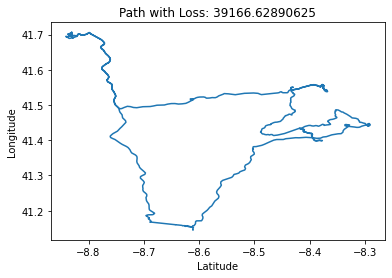

In [172]:
# Visualize paths of biggest outliers
loss, row = highest_loss[9]
count += 1
polyline = row['POLYLINE'].split("],")
polyline = [i.replace("[", '').replace("]", '') for i in polyline]
polyline = [(float(i.split(",")[0]), float(i.split(",")[1])) for i in polyline]
lat = [i[0] for i in polyline]
lon = [i[1] for i in polyline]
plt.plot(lat, lon)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title(f'Path with Loss: {loss}')
plt.show()